In [1]:
charset = ("6", "7", "2", "9")

В качестве функции активации была выбрана **сигмоида** —  гладкая монотонная возрастающая нелинейная функция.

Ее особенность заключается в том, что для любого входного числа *на выходе она дает число в промежутке от 0 до 1*.

In [2]:
from math import exp
def sigmoid(x: float) -> float:
    return 1 / (1 + exp(-x))

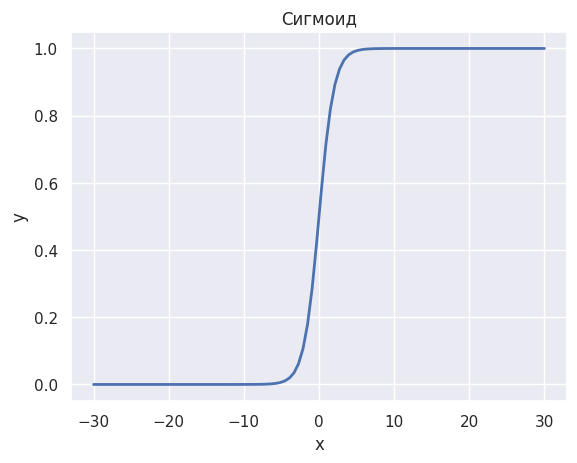

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()


x = np.linspace(-30, 30, 100)
y = [sigmoid(x) for x in x]

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

# ax.set(xlim=(-30, 30), xticks=np.arange(-10, 11, 2),
#        ylim=(0,1),     yticks=np.arange(0, 1.25, 0.25))

ax.set_title('Сигмоид')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [4]:
import random
import numpy as np  

class Neuron:

    def __init__(self, size: tuple[int, int]):
        self.set_weights(size)

    def set_weights(self, size: tuple[int, int]):
        self._weights = np.random.randn(size[0], size[1])
        self._bias = np.random.randn()

    def adjust_weights(self, inputs: np.ndarray, delta: float): 
        self._weights += (inputs * delta)
        self._bias += delta
            

    def get_weights(self):
        return self._weights

    def compute(self, inputs: np.ndarray) -> float:
        weighted_sum = self._weighted_sum(inputs)
        output = self._activation(weighted_sum)

        return output

    def _activation(self, w_sum: float) -> float:
        return sigmoid(w_sum)

    def _weighted_sum(self, inputs: np.ndarray) -> float:
        return float(np.sum(inputs * self._weights) + self._bias)


In [5]:
from PIL import Image
from pathlib import Path

def open_image(path: Path) -> Image.Image:
    with Image.open(path) as im:
        im = im.convert(mode="L")
        return im

In [6]:
def get_data_set(directory: Path) -> dict[str, list[Image.Image]]:
    dataset = {}.fromkeys(charset, [])

    paths = directory.glob('*.png')

    for path in paths:
        char = path.stem[0]
        dataset[char].append(open_image(path))

    return dataset

In [7]:
def image_to_ndarray(img: Image.Image) -> np.ndarray:
    return np.array(img)/255

In [8]:
from enum import Enum

class StopCriteria(Enum):
    epochs = 'epochs'
    weights = 'weights'
    output = 'output'

In [23]:
class PerceptronModel:

    OutputDict = dict[str, float]

    def __init__(self, charset: tuple[str, str, str, str], size: tuple[int, int]):
        self._neurons = dict(zip(charset, (Neuron(size) for i in charset)))
        self.THRESHOLD = 0.5

    def _process_neurons(self, inputs: np.ndarray) -> OutputDict:
        return {char: neuron.compute(inputs) for char, neuron in self._neurons.items()}

    def _adjust_neurons(self, deltas: OutputDict, inputs: np.ndarray, train_speed: float):
        for label, delta in deltas.items():
            adjustment = delta * train_speed
            self._neurons[label].adjust_weights(inputs, adjustment)

    def _calculate_deltas(self, train_char: str, results: OutputDict, train_speed: float) -> tuple[OutputDict, int, int]:
        deltas = {}
        training_total = 0
        training_success = 0

        for neuron_label, res in results.items():
            training_total += 1

            if neuron_label == train_char:
                deltas[neuron_label] = (1 - res)
                if res >= self.THRESHOLD:
                    training_success += 1
                continue
            if neuron_label != train_char:
                deltas[neuron_label] = (0 - res)
                if res <= self.THRESHOLD:
                    training_success += 1
                continue

            training_success += 1
        return deltas, training_success,  training_total
    

    def train_epochs(self, train_speed: float, dataset: dict[str, list[Image.Image]], epochs: int):
        epochs_rate = list()
        for _ in range(epochs):
            epoch_total = 0
            epoch_success = 0
            for dataset_char, images in dataset.items():
                for image in images:
                    inputs = image_to_ndarray(image)
                    results = self._process_neurons(inputs)
                    deltas, success, total = self._calculate_deltas(dataset_char, results, train_speed)
                    self._adjust_neurons(deltas, inputs, train_speed)
                    epoch_total += total
                    epoch_success += success

            # print(f'Точность классификации за эпоху: {epoch_success/epoch_total}')
            epochs_rate.append(epoch_success/epoch_total)


        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 4)
        for (label, neuron), axis in zip(self._neurons.items(), axes[0]):
            weights = neuron.get_weights()


            axis.imshow(weights)
            
            axis.tick_params(
                axis='both',
                labelbottom = False,
                labelleft = False
            )
            axis.set_title(label)
            axis.grid(False)

        fig.suptitle('Тепловая карта весов', y=0.98)
        # fig.set_dpi(150)
        ax = plt.subplot2grid((2, 4), (1, 0), colspan=4)
        ax.plot(epochs_rate)
        ax.set_title('Успех с каждой эпохой')
        plt.show()
        print(f'Успешность последней эпохи: {epochs_rate[-1]}')



    def test(self, dataset: dict[str, list[Image.Image]]):
        correct_count = 0
        total_count = 0

        for dataset_char, images in dataset.items():
            for image in images:
                inputs = image_to_ndarray(image)
                results = self._process_neurons(inputs)
                neural_guess = max(results, key=results.get)

                if neural_guess == dataset_char:
                    correct_count += 1
                total_count += 1

        accuracy = correct_count / total_count
        print(f'Точность классификации при тестировании: {accuracy}')

/tmp/ipykernel_92024/490911862.py:76: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((2, 4), (1, 0), colspan=4)


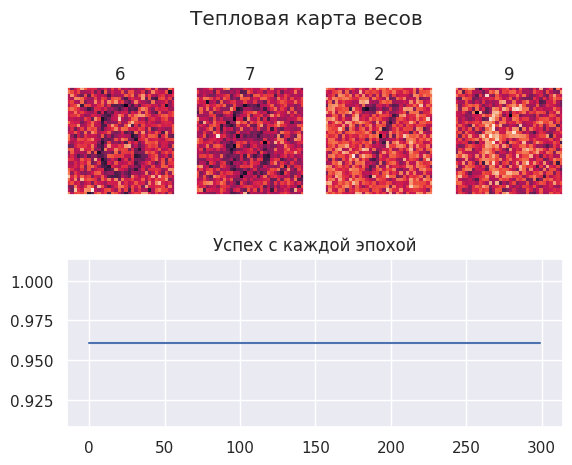

Успешность последней эпохи: 0.9609375
Точность классификации при тестировании: 0.25


In [24]:
train_folder = Path(f'../res/images/train/')
test_folder = Path(f'../res/images/test/')

perceptron = PerceptronModel(charset = charset, size = (32, 32))

perceptron.train_epochs(train_speed=2, epochs= 300, dataset=get_data_set(train_folder))
perceptron.test(dataset=get_data_set(test_folder))